# TODO:

1. Find some good candidates for binary classification including ensembles
    1. 5 different models
2. Write a pipeline for testing and analysis of the results
3. Create code documentation :)
4. Maybe extract the functions to separate .py to make the notebook cleaner
3. Write the report
4. Prepare the presentation

# Imports and Consts

In [82]:
import pickle
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import itertools
from enum import Enum
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
import seaborn as sns

# Functions

## Generate parameters

- takes any number of arrays and returns an array of dictionaries with keys as array names and values, all possible combinations

In [54]:
# Get name of a variable as string
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [55]:
def generateParameters(arrays):
    allCombinations = list(itertools.product(*arrays))
    allCombinations = [list(elem) for elem in allCombinations]
    arrayNames = []
    for array in arrays:
        arrayNames.append(namestr(array, globals())[0])
    return [dict(zip(arrayNames, value)) for value in allCombinations]

- example usage, create arrays with parameters (their names should be the same as desired parameter names), pass them in an array to generateParamters function

In [56]:
arr1 = [1, 2, 7]
arr2 = [3, 4, 8]
generateParameters([arr1, arr2])

[{'arr1': 1, 'arr2': 3},
 {'arr1': 1, 'arr2': 4},
 {'arr1': 1, 'arr2': 8},
 {'arr1': 2, 'arr2': 3},
 {'arr1': 2, 'arr2': 4},
 {'arr1': 2, 'arr2': 8},
 {'arr1': 7, 'arr2': 3},
 {'arr1': 7, 'arr2': 4},
 {'arr1': 7, 'arr2': 8}]

## Experiment process

Scoring function, based on which, the best model is selected. Score is calculated according to task description: +10 points for each correctly classified positive class, -200 points for each feature used

In [57]:
def getScore(y_true, y_pred, featuresUsed):
    score = 0
    correct = 0
    for i, y in enumerate(y_true):
        if y == y_pred[i]:
            correct += 1
    score = 10 * correct - 200 * featuresUsed
    return score

Main experiment loop, each chosen classifier is tested with different methods of feature selection and different parameters

In [58]:
def performExperiment(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    finalResult = getScore(y_test, y_pred, len(X_train[0]))
    # Take only 1000 of the highest class 1 probabilities
    # TODO: Turn it into a dataframe and keep track of the indexes
    # finalResult = np.sort(result[:, 1])[::-1][:1000]

    return finalResult

## Model helpers

- definition of available models and feature selection methods

- getters for models and feature selection methods

In [59]:
class ModelType(Enum):
    LDA = 0
    QDA = 1
    DecisionTree = 2

In [60]:
def getModel(modelType, arguments):
    match modelType:
        case ModelType.LDA:
            return LinearDiscriminantAnalysis(**arguments)
        case ModelType.QDA:
            return QuadraticDiscriminantAnalysis(**arguments)
        case ModelType.DecisionTree:
            return DecisionTreeClassifier(**arguments)

In [61]:
class FeatureSelectorType(Enum):
    NoFeatureSelection = 0
    KBest = 1

In [73]:
class NoFeatureSelection:
    def fit_transform(self, X, y):
        return X

In [63]:
def getFeatureSelector(selectorType, arguments):
    match selectorType:
        case FeatureSelectorType.NoFeatureSelection:
            return NoFeatureSelection(**arguments)
        case FeatureSelectorType.KBest:
            return SelectKBest(**arguments)

# Load Data

load the training and test data in a format specified by task description

In [64]:
with open("./Dataset/x_test.txt") as file:
    X_test = [[float(digit) for digit in line.split()] for line in file]


with open("./Dataset/x_train.txt") as file:
    X_train = [[float(digit) for digit in line.split()] for line in file]


with open("./Dataset/y_train.txt") as file:
    y_train = [[float(digit) for digit in line.split()] for line in file]

In the X_test there are 500 features and 5000 observations, y_train contains 5000 values, X_train contains 500 features and 5000 observations

In [65]:
print("X_test datapoints:", len(X_test), " features:", len(X_test[0]))
print("X_train datapoints:", len(X_train), " features:", len(X_train[0]))
print("y_train datapoints:", len(y_train))

X_test datapoints: 5000  features: 500
X_train datapoints: 5000  features: 500
y_train datapoints: 5000


# Experiment

## Parameters

In [66]:
# TODO: Create parameter arrays

# LDA
solver = ["svd"]
ldaParameters = generateParameters([solver])


models = [{"model": ModelType.LDA, "parameters": ldaParameters}]

In [68]:
score_func = [f_classif]
k = [5, 10, 20, 40, 80]
kBestParameters = generateParameters([score_func, k])

featureSelectors = [
    {"model": FeatureSelectorType.NoFeatureSelection, "parameters": [{}]},
    {"model": FeatureSelectorType.KBest, "parameters": kBestParameters},
]

## Main experiment loop

1. for now just do one train test split
2. For each of the models:
    1. For each of the feature selectors:
        1. Calculate the score of the given combination of model+feature selector based on the +10 for each correct prediction and -200 for each feature used.


## Conducting the experiment

In [89]:
y_train = np.ravel(y_train, order="C")

In [90]:
%%time
results=[]
for model in models:
    for modelParameters in model['parameters']:
        

        for featureSelector in featureSelectors:
            for featureSelectorParameters in featureSelector['parameters']:
                selector=getFeatureSelector(featureSelector["model"],featureSelectorParameters)
                X_new=selector.fit_transform(X_train,y_train)

                X_split_train, X_split_test, y_split_train, y_split_test = train_test_split(X_new, y_train, test_size=0.33, random_state=42)

                result = performExperiment(X_train=X_split_train, y_train=y_split_train, X_test=X_split_test, 
                y_test=y_split_test, model=getModel(model['model'], modelParameters))

                results.append([result,model['model'].name,modelParameters,featureSelector["model"].name,featureSelectorParameters])
with open("./Results/results", "wb") as f:
    pickle.dump(results, f)

CPU times: total: 2.73 s
Wall time: 1.92 s


In [91]:
resultsDf = pd.DataFrame(
    results,
    columns=[
        "score",
        "model",
        "model_parameters",
        "feature_selector",
        "selector_parameters",
    ],
)

In [92]:
resultsDf

,score,model,model_parameters,feature_selector,selector_parameters
0,-91740,LDA,{'solver': 'svd'},NoFeatureSelection,{}
1,7760,LDA,{'solver': 'svd'},KBest,{'score_func': <function f_classif at 0x000002...
2,6780,LDA,{'solver': 'svd'},KBest,{'score_func': <function f_classif at 0x000002...
3,4760,LDA,{'solver': 'svd'},KBest,{'score_func': <function f_classif at 0x000002...
4,1190,LDA,{'solver': 'svd'},KBest,{'score_func': <function f_classif at 0x000002...
5,-6710,LDA,{'solver': 'svd'},KBest,{'score_func': <function f_classif at 0x000002...


# Results

In [93]:
with open(r"./Results/results", "rb") as input_file:
    results = pickle.load(input_file)

In [94]:
resultsDf = pd.DataFrame(
    results,
    columns=[
        "score",
        "model",
        "model_parameters",
        "feature_selector",
        "selector_parameters",
    ],
)

# TODO: How to extract results, say per value of k of KBest classifier? Maybe they should be saved in a different way that would allow for that?

In [95]:
def extractParamterInformation(df, paramterColumnName, parameterName):
    df[parameterName] = df[paramterColumnName][parameterName]
    pass

In [96]:
extractParamterInformation(resultsDf, "selector_parameters", "k")

KeyError: 'k'

<Axes: xlabel='model', ylabel='score'>

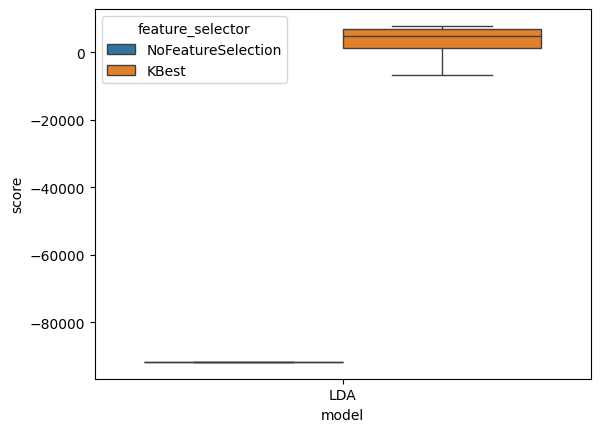

In [85]:
sns.boxplot(data=resultsDf, x="model", y="score", hue="feature_selector")